In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 100

In [3]:
model_name = 'depthwise_with_pooling_(32-64-126)_(64).tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,33,seq_001627.jpg
1,29,seq_001375.jpg
2,33,seq_000955.jpg
3,44,seq_001175.jpg
4,26,seq_000394.jpg
...,...,...
1995,37,seq_001642.jpg
1996,32,seq_000089.jpg
1997,26,seq_001158.jpg
1998,30,seq_000804.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1, pooling = False):
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(input)
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D()(x)
        
    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128], 2, pooling=True)
outputs = basic_dense_block(covnet, [64])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-12 18:44:45.624242: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-12 18:44:45.624265: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-12 18:44:45.624273: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-12 18:44:45.624599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 18:44:45.624763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/100


2023-12-12 18:44:46.869360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 680.6293 - mae: 22.1144INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 22s 607ms/step - loss: 680.6293 - mae: 22.1144 - val_loss: 1029.3896 - val_mae: 31.3297
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 283.3567 - mae: 13.4419INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 572ms/step - loss: 283.3567 - mae: 13.4419 - val_loss: 1026.0482 - val_mae: 31.2764
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 240.0313 - mae: 12.1804INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 552ms/step - loss: 240.0313 - mae: 12.1804 - val_loss: 1025.2472 - val_mae: 31.2635
Epoch 4/100
32/32 [==============================] - 17s 518ms/step - loss: 193.3148 - mae: 10.9337 - val_loss: 1027.6396 - val_mae: 31.3018
Epoch 5/100
32/32 [==============================] - 17s 517ms/step - loss: 155.7001 - mae: 9.7708 - val_loss: 1033.5415 - val_mae: 31.3959
Epoch 6/100
32/32 [==============================] - 17s 518ms/step - loss: 130.4877 - mae: 8.9152 - val_loss: 1050.3270 - val_mae: 31.6621
Epoch 7/100
32/32 [==============================] - 17s 521ms/step - loss: 111.6858 - mae: 8.5506 - val_loss: 1077.4333 - val_mae: 32.0873
Epoch 8/100
32/32 [==============================] - 18s 567ms/step - loss: 92.3687 - mae: 7.6467 - val_loss: 1127.9951 - val_mae: 32.8658
Epoch 9/100
32/32 [==============================] - 18s 567ms/step - loss: 76.5968 - mae: 7.1620 - val_loss: 1158.2365 - val_mae: 33.3231
Epoch 10/100
32/32 [============

INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 20s 637ms/step - loss: 30.7836 - mae: 4.4955 - val_loss: 940.3490 - val_mae: 30.1007
Epoch 17/100
32/32 [==============================] - ETA: 0s - loss: 30.7521 - mae: 4.5312INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 590ms/step - loss: 30.7521 - mae: 4.5312 - val_loss: 799.3826 - val_mae: 27.7258
Epoch 18/100
32/32 [==============================] - ETA: 0s - loss: 27.5133 - mae: 4.2021INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 538ms/step - loss: 27.5133 - mae: 4.2021 - val_loss: 656.6373 - val_mae: 25.1326
Epoch 19/100
32/32 [==============================] - ETA: 0s - loss: 25.9022 - mae: 4.0446INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 560ms/step - loss: 25.9022 - mae: 4.0446 - val_loss: 318.6638 - val_mae: 17.3119
Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 24.2135 - mae: 3.9121INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 18s 569ms/step - loss: 24.2135 - mae: 3.9121 - val_loss: 186.0005 - val_mae: 13.0472
Epoch 21/100
32/32 [==============================] - ETA: 0s - loss: 20.3289 - mae: 3.6140INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 580ms/step - loss: 20.3289 - mae: 3.6140 - val_loss: 103.0517 - val_mae: 9.4884
Epoch 22/100
32/32 [==============================] - 18s 541ms/step - loss: 18.8190 - mae: 3.4680 - val_loss: 108.2416 - val_mae: 9.7895
Epoch 23/100
32/32 [==============================] - ETA: 0s - loss: 19.0829 - mae: 3.4279INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 571ms/step - loss: 19.0829 - mae: 3.4279 - val_loss: 70.8629 - val_mae: 7.7065
Epoch 24/100
32/32 [==============================] - ETA: 0s - loss: 18.1050 - mae: 3.3882INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 601ms/step - loss: 18.1050 - mae: 3.3882 - val_loss: 64.0974 - val_mae: 7.2897
Epoch 25/100
32/32 [==============================] - ETA: 0s - loss: 15.9897 - mae: 3.1721INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 20s 592ms/step - loss: 15.9897 - mae: 3.1721 - val_loss: 12.2347 - val_mae: 2.7717
Epoch 26/100
32/32 [==============================] - ETA: 0s - loss: 16.8787 - mae: 3.2198INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 566ms/step - loss: 16.8787 - mae: 3.2198 - val_loss: 10.8283 - val_mae: 2.6166
Epoch 27/100
32/32 [==============================] - 17s 515ms/step - loss: 16.9641 - mae: 3.2666 - val_loss: 12.6460 - val_mae: 2.9164
Epoch 28/100
32/32 [==============================] - 16s 510ms/step - loss: 13.9162 - mae: 2.9083 - val_loss: 28.4765 - val_mae: 4.5097
Epoch 29/100
32/32 [==============================] - 17s 516ms/step - loss: 14.3455 - mae: 2.9454 - val_loss: 16.4220 - val_mae: 3.2251
Epoch 30/100
32/32 [==============================] - 17s 527ms/step - loss: 13.1917 - mae: 2.8314 - val_loss: 21.0973 - val_mae: 3.9532
Epoch 31/100
32/32 [==============================] - ETA: 0s - loss: 13.0359 - mae: 2.8095INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 580ms/step - loss: 13.0359 - mae: 2.8095 - val_loss: 7.8632 - val_mae: 2.2459
Epoch 32/100
32/32 [==============================] - 18s 545ms/step - loss: 11.3786 - mae: 2.5633 - val_loss: 13.9973 - val_mae: 3.0931
Epoch 33/100
32/32 [==============================] - 17s 526ms/step - loss: 11.7134 - mae: 2.5943 - val_loss: 39.5668 - val_mae: 5.4703
Epoch 34/100
32/32 [==============================] - 17s 530ms/step - loss: 11.9156 - mae: 2.6497 - val_loss: 11.5635 - val_mae: 2.8042
Epoch 35/100
32/32 [==============================] - ETA: 0s - loss: 11.3971 - mae: 2.5474INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 19s 603ms/step - loss: 11.3971 - mae: 2.5474 - val_loss: 7.7456 - val_mae: 2.2318
Epoch 36/100
32/32 [==============================] - 19s 554ms/step - loss: 11.0490 - mae: 2.5408 - val_loss: 15.4940 - val_mae: 3.1404
Epoch 37/100
32/32 [==============================] - 18s 546ms/step - loss: 11.2028 - mae: 2.5286 - val_loss: 8.9511 - val_mae: 2.3613
Epoch 38/100
32/32 [==============================] - 18s 547ms/step - loss: 11.3375 - mae: 2.5351 - val_loss: 9.4546 - val_mae: 2.4292
Epoch 39/100
32/32 [==============================] - 17s 542ms/step - loss: 10.0015 - mae: 2.3594 - val_loss: 12.3853 - val_mae: 2.7679
Epoch 40/100
32/32 [==============================] - 17s 516ms/step - loss: 10.1847 - mae: 2.3702 - val_loss: 12.3069 - val_mae: 2.8937
Epoch 41/100
32/32 [==============================] - ETA: 0s - loss: 10.3658 - mae: 2.4551INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


INFO:tensorflow:Assets written to: depthwise_with_pooling_(32-64-126)_(64).tf/assets


32/32 [==============================] - 17s 546ms/step - loss: 10.3658 - mae: 2.4551 - val_loss: 7.2649 - val_mae: 2.1571
Epoch 42/100
32/32 [==============================] - 17s 511ms/step - loss: 11.2709 - mae: 2.5629 - val_loss: 9.0552 - val_mae: 2.4327
Epoch 43/100
32/32 [==============================] - 16s 509ms/step - loss: 11.1514 - mae: 2.5685 - val_loss: 15.6817 - val_mae: 3.3474
Epoch 44/100
32/32 [==============================] - 17s 519ms/step - loss: 10.6933 - mae: 2.5504 - val_loss: 8.1777 - val_mae: 2.2872
Epoch 45/100
32/32 [==============================] - 17s 517ms/step - loss: 10.5974 - mae: 2.4181 - val_loss: 8.4704 - val_mae: 2.2838
Epoch 46/100
32/32 [==============================] - 17s 527ms/step - loss: 10.0541 - mae: 2.3518 - val_loss: 20.6680 - val_mae: 3.7236
Epoch 47/100
32/32 [==============================] - 17s 539ms/step - loss: 10.0660 - mae: 2.3640 - val_loss: 9.3869 - val_mae: 2.4069
Epoch 48/100
32/32 [==============================] - 17s 5

In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 119ms/step - loss: 8.8506 - mae: 2.3599


[8.850619316101074, 2.359884738922119]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 124ms/step - loss: 8.8049 - mae: 2.3342


[8.804919242858887, 2.334153175354004]

# Represent history

In [22]:
print(history.history.keys())
epochs = (0, 100)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


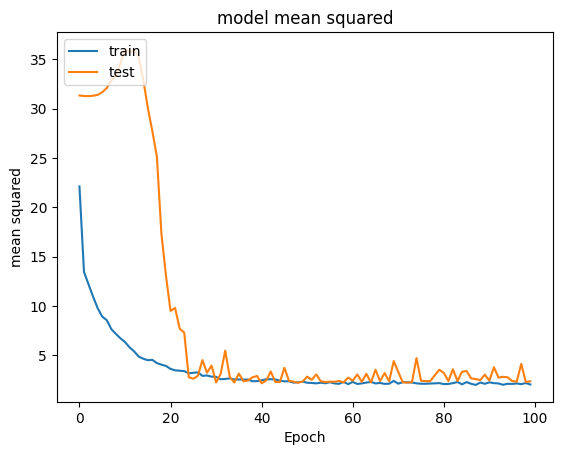

In [23]:
plt.plot(history.history['mae'][epochs[0]:epochs[1]])
plt.plot(history.history['val_mae'][epochs[0]:epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

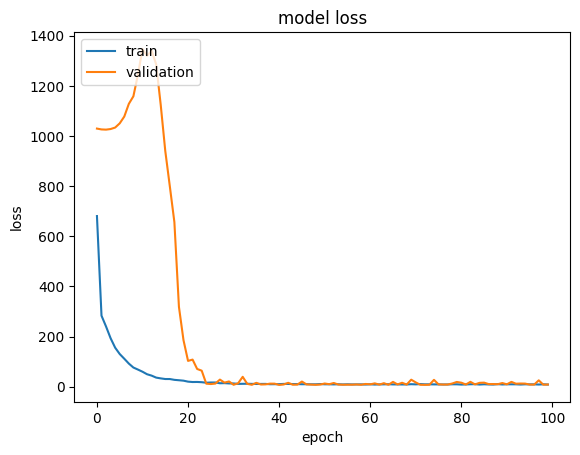

In [24]:
plt.plot(history.history['loss'][epochs[0]:epochs[1]])
plt.plot(history.history['val_loss'][epochs[0]:epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet